#Trabalho para a disciplina Álgebra Linear da graduação de Ciência de Dados e Inteligência Artificial.
##Conjunto de Dados
Os preços das moradias foram obtidos do Pararius.nl como um instantâneo em agosto de 2021. Os dados forneceram recursos como preço, área útil, número de quarto, coordenadas de cada listagem (através da utilização da API Mapbox).  
Na tentativa de inserir novas variáveis que pudessem melhorar o modelo, foram criadas novas colunas fornecendo a distância entre as coordenadas de cada listagem até pontos como a Estação Central de Trem, a Universidade de Amsterdam e Vondelpark. A partir de um dataframe extraído do Kaggle com a correspondência entre o Zip e os distritos que dividem a cidade, também criamos uma coluna com os respectivos distritos de cada casa. 




In [ ]:
#Bibliotecas
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import math
import requests
import seaborn as sns
from shapely.geometry import Point
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
#Importanto os dados do arquivo CSV extraído da plataforma Kaggle 
df_1 = pd.read_csv("HousingPrices-Amsterdam-August-2021.csv")

In [ ]:
#Visualização da tabela dos dados
df_1.head()

,Unnamed: 0,Address,Zip,Price,Area,Room,Lon,Lat
0,1,"Blasiusstraat 8 2, Amsterdam",1091 CR,685000.0,64,3,4.907736,52.356157
1,2,"Kromme Leimuidenstraat 13 H, Amsterdam",1059 EL,475000.0,60,3,4.850476,52.348586
2,3,"Zaaiersweg 11 A, Amsterdam",1097 SM,850000.0,109,4,4.944774,52.343782
3,4,"Tenerifestraat 40, Amsterdam",1060 TH,580000.0,128,6,4.789928,52.343712
4,5,"Winterjanpad 21, Amsterdam",1036 KN,720000.0,138,5,4.902503,52.410538


In [ ]:
df_1.info()
#É possível verificar que dos 924 valores do Price, 920 são não nulos, o que significa que temos 4 valores nulos nessa coluna.
#Na etapa de preparação dos dados para modelos, é necessário tratar os dados faltantes. Nesse caso, optamos por eliminar as linhas faltantes.
#Uma alternativa seria preencher os valores com a média da coluna. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 924 entries, 0 to 923
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  924 non-null    int64  
 1   Address     924 non-null    object 
 2   Zip         924 non-null    object 
 3   Price       920 non-null    float64
 4   Area        924 non-null    int64  
 5   Room        924 non-null    int64  
 6   Lon         924 non-null    float64
 7   Lat         924 non-null    float64
dtypes: float64(3), int64(3), object(2)
memory usage: 57.9+ KB


In [ ]:
#Eliminação da coluna "Unnamed: 0"
df_2 = df_1.drop('Unnamed: 0', axis=1)
#Descobrindo os índices dos valores faltantes
df_2[df_2["Price"].isna()].index
#Eliminação das linhas com valores faltantes 
df_2.drop([73, 321, 610, 727], inplace = True)
df_2.reset_index(inplace=True)
df_2.drop("index", axis=1, inplace=True)

In [ ]:
df_2.info()
#Agora podemos perceber que todas as colunas possuem 920 entradas. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Address  920 non-null    object 
 1   Zip      920 non-null    object 
 2   Price    920 non-null    float64
 3   Area     920 non-null    int64  
 4   Room     920 non-null    int64  
 5   Lon      920 non-null    float64
 6   Lat      920 non-null    float64
dtypes: float64(3), int64(2), object(2)
memory usage: 50.4+ KB


In [ ]:
df_2.describe()
#Somente dados numéricos aparecem nessa descrição estatística

,Price,Area,Room,Lon,Lat
count,9.200000e+02,920.000000,920.00000,920.000000,920.000000
mean,6.220654e+05,95.607609,3.56413,4.888652,52.363271
std,5.389942e+05,56.849699,1.57103,0.053118,0.024054
min,1.750000e+05,21.000000,1.00000,4.644819,52.291519
25%,3.500000e+05,60.000000,3.00000,4.855834,52.351925
50%,4.670000e+05,83.000000,3.00000,4.886818,52.364499
75%,7.000000e+05,113.000000,4.00000,4.922337,52.377545
max,5.950000e+06,623.000000,14.00000,5.029122,52.423805


In [ ]:
df_model_1 = df_2[["Price","Area", "Room","Lat", "Lon"]]

In [ ]:
#Verificando se os valores são finitos
np.isfinite(df_model_1.all())

Price    True
Area     True
Room     True
Lat      True
Lon      True
dtype: bool

In [ ]:
#Confirmando se existem valores nulos
df_model_1.isnull().values.any()

False

In [ ]:
df_model_1['Price'] = df_model_1['Price'].astype(float)

In [ ]:
df_model_1.corr()

,Price,Area,Room,Lat,Lon
Price,1.000000,0.835090,0.623448,0.062196,-0.013561
Area,0.835090,1.000000,0.808285,0.014179,0.021762
Room,0.623448,0.808285,1.000000,-0.021168,-0.025753
Lat,0.062196,0.014179,-0.021168,1.000000,-0.183445
Lon,-0.013561,0.021762,-0.025753,-0.183445,1.000000


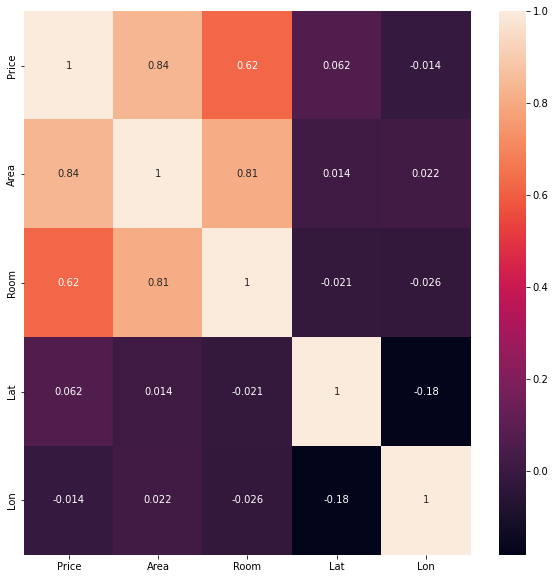

In [ ]:
#Representação gráfica da correlação 
fig = plt.figure(figsize=(10, 10))
sns.heatmap(df_model_1.corr(), annot=True) 

<Figure size 720x1080 with 0 Axes>

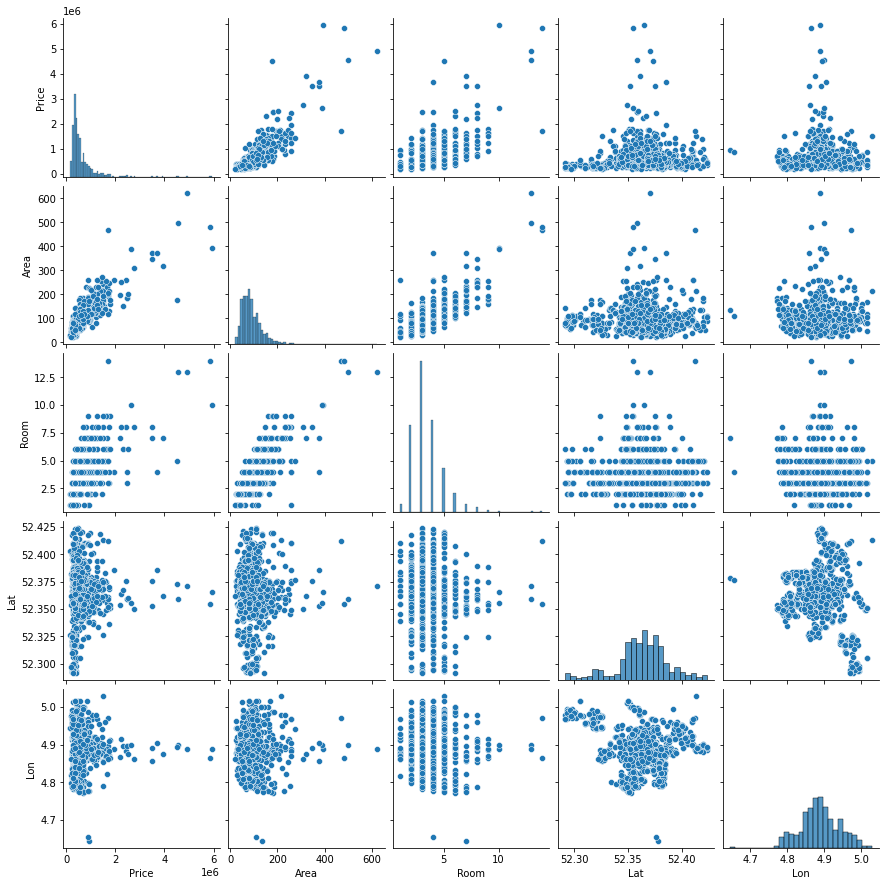

In [ ]:
fig = plt.figure(figsize=(10, 15))
sns.pairplot(df_model_1)

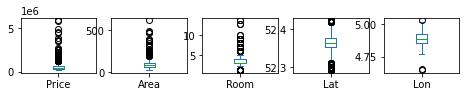

In [ ]:
df_model_1.plot(kind='box', subplots=True, layout=(10,10), sharex=False, sharey=False, figsize=(16,12))
plt.show()

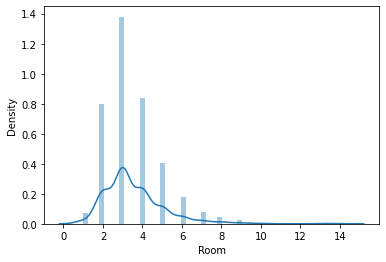

<Figure size 432x288 with 0 Axes>

In [ ]:
sns.distplot(df_model_1["Room"], hist=True);
fig = plt.figure()

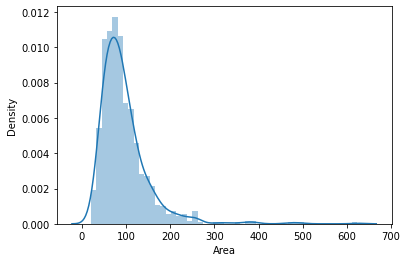

<Figure size 432x288 with 0 Axes>

In [ ]:
sns.distplot(df_model_1["Area"], hist=True);
fig = plt.figure()

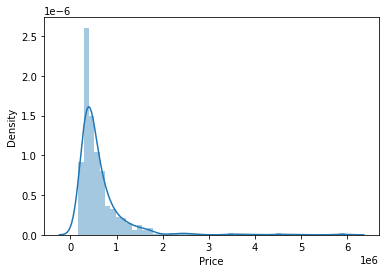

<Figure size 432x288 with 0 Axes>

In [ ]:
sns.distplot(df_model_1["Price"], hist=True);
fig = plt.figure()

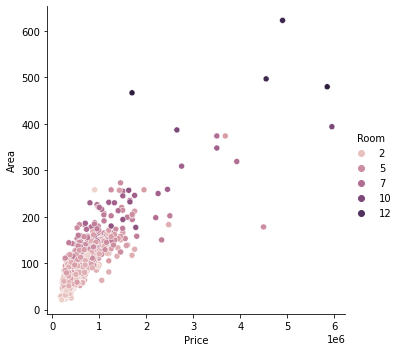

In [ ]:
sns.relplot(x="Price", y="Area", hue="Room", data=df_model_1)
plt.show()

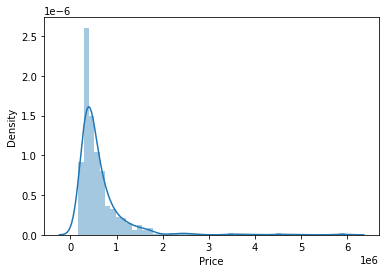

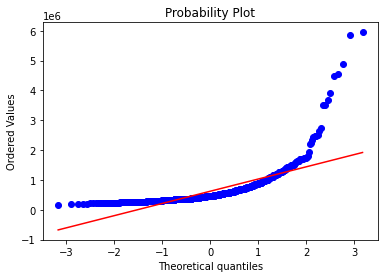

In [ ]:
from scipy import stats
#Histograma e gráfico de probabilidade
sns.distplot(df_model_1["Price"], hist=True);
fig = plt.figure()
res = stats.probplot(df_model_1["Price"], plot=plt)

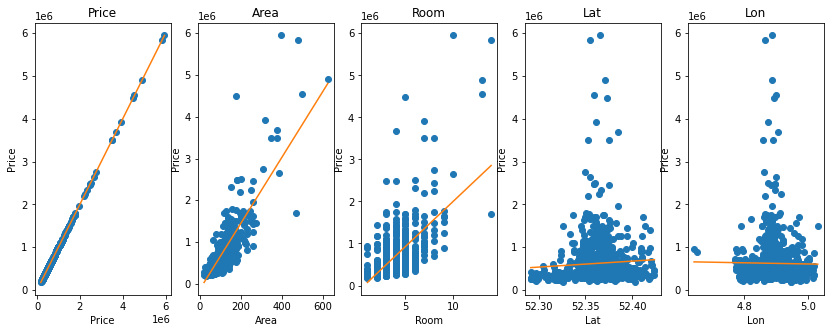

In [ ]:
price = df_model_1["Price"]

fig = plt.figure(figsize=(20, 5))
for i, col in enumerate(df_model_1.columns[0:6]):
    plt.subplot(1, 7, i+1)
    x = df_model_1[col]
    y = price
    plt.plot(x, y, 'o')
    # Criar linha de regressão
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Price')
plt.show()

##Modelo de Regressão Linear Simples: variáveis área e preço

In [ ]:
X = df_model_1[['Area']]
y = df_model_1.Price
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3)

In [ ]:
# Modelo LinearRegression
lr_regr = LinearRegression()
# Treinamento do modelo
lr_regr.fit(X_train1, y_train1)
# Predição com os dados separados para teste
y_pred = lr_regr.predict(X_test1)
# Visualização dos 10 primeiros resultados
y_pred[:10]

array([ 395051.49633696,  657311.27965228,  641416.74733014,
        236106.17311556,  299684.30240412,  244053.43927663,
       2310342.64115488,  887781.99832331,  236106.17311556,
        228158.90695449])

In [ ]:
print('Erro Médio Absoluto: %.2f' % mean_absolute_error(y_test1, y_pred))

Erro Médio Absoluto: 202080.63


In [ ]:
print('Erro Quadrático Médio: %.2f' % mean_squared_error(y_test1, y_pred))

Erro Quadrático Médio: 114794459470.09


In [ ]:
print('Coeficiente de Determinação R2 Score: %.2f' % r2_score(y_test1, y_pred))

Coeficiente de Determinação R2 Score: 0.65


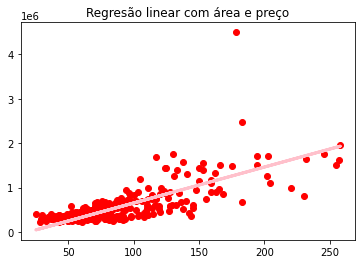

In [ ]:
plt.scatter(X_test1, y_test1,  color='red')
plt.plot(X_test1, y_pred, color='pink', linewidth=3)
plt.title("Regresão linear com área e preço")
plt.show()

##Modelo de Regressão Linear Múltipla: variáveis área, número de quartos, latitude, longitude e preço

In [ ]:
X = df_model_1.drop(['Price'], axis = 1)
y = df_model_1["Price"]

In [ ]:
# Criando conjunto de teste e de treino
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.3)
# Modelo LinearRegression
lr_regr = LinearRegression()
# Treinamento do modelo
lr_regr.fit(X_train2, y_train2)
# Predição com os dados separados para teste
y_pred2 = lr_regr.predict(X_test2)
# Visualização dos 10 primeiros resultados
y_pred2[:10]

array([ 764861.46228884,  286034.38276035,  784085.95065206,
        676580.04612945,  530661.20797391,  607365.78010823,
       1311299.57671033, 2809341.30085157,  658154.81979305,
        629759.6825895 ])

In [ ]:
print('Erro Médio Absoluto: %.2f' % mean_absolute_error(y_test2, y_pred2))

Erro Médio Absoluto: 182310.26


In [ ]:
print('Erro Quadrático Médio: %.2f' % mean_squared_error(y_test2, y_pred2))

Erro Quadrático Médio: 116285057175.25


In [ ]:
print('Coeficiente de Determinação R2 Score: %.2f' % r2_score(y_test2, y_pred2))

Coeficiente de Determinação R2 Score: 0.73


###Função que calcula a distância das coordenadas das casas para pontos relevantes em Amsterdã
### Cabe destacar que o ideal seria realizar um API do Google, para extrair o tempo através de caminhada de um ponto até o outro. Entretanto, isso demandaria maior tempo e investimento financeiro, que fogem do escopo deste trabalho, por conta disso, optamos por uma solução matemática: a distância euclidiana das coordenadas das casas em relação à Estação Central de Trem, à Universidade de Amsterdã e ao Vondelpark.  

In [ ]:
def distance_from_lat_long (df, lat, long, nome):
     x = df.shape[0]
     lista = []
     for i in range(0, x):
        a = df.Lat[i]
        b = df.Lon[i]
        y = math.sqrt(((a - lat)**2 + (b - long))**2)
        lista.append(y)
        serie_distances = pd.Series(lista)
        df_distances = pd.concat([df, serie_distances.rename(nome)], axis=1)
     return df_distances

#Distância da Estação Central de Amsterdã
df_3 = distance_from_lat_long(df_2,  52.378333, 4.899431,'Dist_Centraal')
#Distância da Universidade de Amsterdã
df_4 = distance_from_lat_long(df_3, 52.357044, 4.950124, 'Dist_University')
#Distância do Vondelpark
df_5 = distance_from_lat_long(df_4, 52.357994, 4.8686487, 'Dist_Vondelpark')
df_5

,Address,Zip,Price,Area,Room,Lon,Lat,Dist_Centraal,Dist_University,Dist_Vondelpark
0,"Blasiusstraat 8 2, Amsterdam",1091 CR,685000.0,64,3,4.907736,52.356157,0.008797,0.042387,0.039091
1,"Kromme Leimuidenstraat 13 H, Amsterdam",1059 EL,475000.0,60,3,4.850476,52.348586,0.048070,0.099576,0.018084
2,"Zaaiersweg 11 A, Amsterdam",1097 SM,850000.0,109,4,4.944774,52.343782,0.046537,0.005174,0.076327
3,"Tenerifestraat 40, Amsterdam",1060 TH,580000.0,128,6,4.789928,52.343712,0.108304,0.160018,0.078517
4,"Winterjanpad 21, Amsterdam",1036 KN,720000.0,138,5,4.902503,52.410538,0.004109,0.044759,0.036615
...,...,...,...,...,...,...,...,...,...,...
915,"Ringdijk, Amsterdam",1097 AE,750000.0,117,1,4.927757,52.354173,0.028910,0.022359,0.059123
916,"Kleine Beerstraat 31, Amsterdam",1033 CP,350000.0,72,3,4.890612,52.414587,0.007505,0.056201,0.025166
917,"Stuyvesantstraat 33 II, Amsterdam",1058 AK,350000.0,51,3,4.856935,52.363256,0.042269,0.093150,0.011686
918,"John Blankensteinstraat 51, Amsterdam",1095 MB,599000.0,113,4,4.965731,52.375268,0.066309,0.015939,0.097381


In [ ]:
#Dataframe exportado do Kaggle com os distritos por código postal
district_zipcode = pd.DataFrame(np.array([
    [1011, 1018, 1], [1019, 1019, 2], [1020, 1029, 3],
    [1030, 1039, 4], [1040, 1049, 5], [1050, 1059, 6], 
    [1060, 1069, 7], [1070, 1083, 8], [1086, 1099, 9], 
    [1100, 1108, 10], [1109, 1109, 11]]), 
    columns = ['under', 'upper', 'district_id'])

district_zipcode

,under,upper,district_id
0,1011,1018,1
1,1019,1019,2
2,1020,1029,3
3,1030,1039,4
4,1040,1049,5
5,1050,1059,6
6,1060,1069,7
7,1070,1083,8
8,1086,1099,9
9,1100,1108,10


In [ ]:
#Função para definir o distrito da residência
def criar_temp(x):
  result = x.split(' ', 1)[0]
  return int(result)

df_5['temp'] = df_5['Zip'].apply(criar_temp)

def criar_district(x):
  result = district_zipcode.loc[(district_zipcode['under'] <= x) & (district_zipcode['upper'] >= x), 'district_id']
  return result.values[0]

df_5['district'] = df_5['temp'].apply(criar_district)

df_5

,Address,Zip,Price,Area,Room,Lon,Lat,Dist_Centraal,Dist_University,Dist_Vondelpark,temp,district
0,"Blasiusstraat 8 2, Amsterdam",1091 CR,685000.0,64,3,4.907736,52.356157,0.008797,0.042387,0.039091,1091,9
1,"Kromme Leimuidenstraat 13 H, Amsterdam",1059 EL,475000.0,60,3,4.850476,52.348586,0.048070,0.099576,0.018084,1059,6
2,"Zaaiersweg 11 A, Amsterdam",1097 SM,850000.0,109,4,4.944774,52.343782,0.046537,0.005174,0.076327,1097,9
3,"Tenerifestraat 40, Amsterdam",1060 TH,580000.0,128,6,4.789928,52.343712,0.108304,0.160018,0.078517,1060,7
4,"Winterjanpad 21, Amsterdam",1036 KN,720000.0,138,5,4.902503,52.410538,0.004109,0.044759,0.036615,1036,4
...,...,...,...,...,...,...,...,...,...,...,...,...
915,"Ringdijk, Amsterdam",1097 AE,750000.0,117,1,4.927757,52.354173,0.028910,0.022359,0.059123,1097,9
916,"Kleine Beerstraat 31, Amsterdam",1033 CP,350000.0,72,3,4.890612,52.414587,0.007505,0.056201,0.025166,1033,4
917,"Stuyvesantstraat 33 II, Amsterdam",1058 AK,350000.0,51,3,4.856935,52.363256,0.042269,0.093150,0.011686,1058,6
918,"John Blankensteinstraat 51, Amsterdam",1095 MB,599000.0,113,4,4.965731,52.375268,0.066309,0.015939,0.097381,1095,9


In [ ]:
#Eliminando colunas que podem ser descartadas
df_6 = df_5.drop('temp', axis=1)
df_7 = df_6.drop('Address', axis=1)
df_8 = df_7.drop('Zip', axis=1)
df_model_2 = df_8

## Modelo de Regressão Linear Múltipla incluindo a base de dados originais mais as novas variáveis de distância até a Estação Central, Vondelpark e Universidade de Amsterdã e distrito. 

In [ ]:
df_model_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Price            920 non-null    float64
 1   Area             920 non-null    int64  
 2   Room             920 non-null    int64  
 3   Lon              920 non-null    float64
 4   Lat              920 non-null    float64
 5   Dist_Centraal    920 non-null    float64
 6   Dist_University  920 non-null    float64
 7   Dist_Vondelpark  920 non-null    float64
 8   district         920 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 64.8 KB


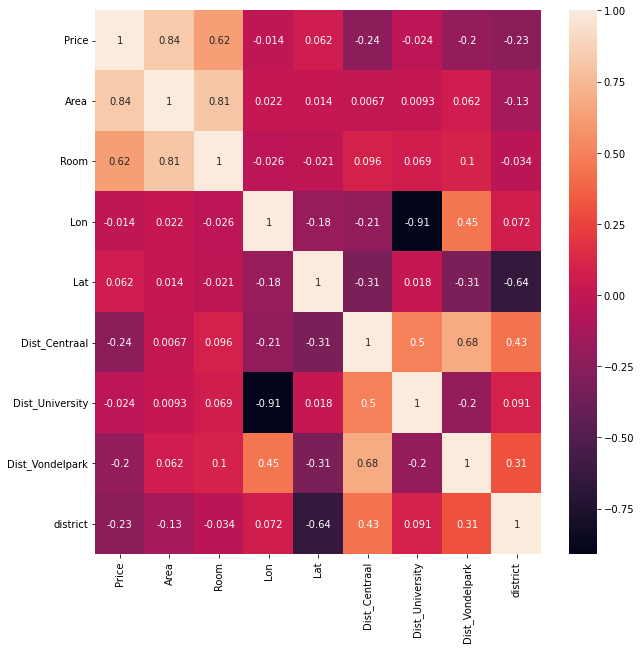

In [ ]:
fig = plt.figure(figsize=(10, 10))
sns.heatmap(df_model_2.corr(), annot=True) 

<Figure size 720x1080 with 0 Axes>

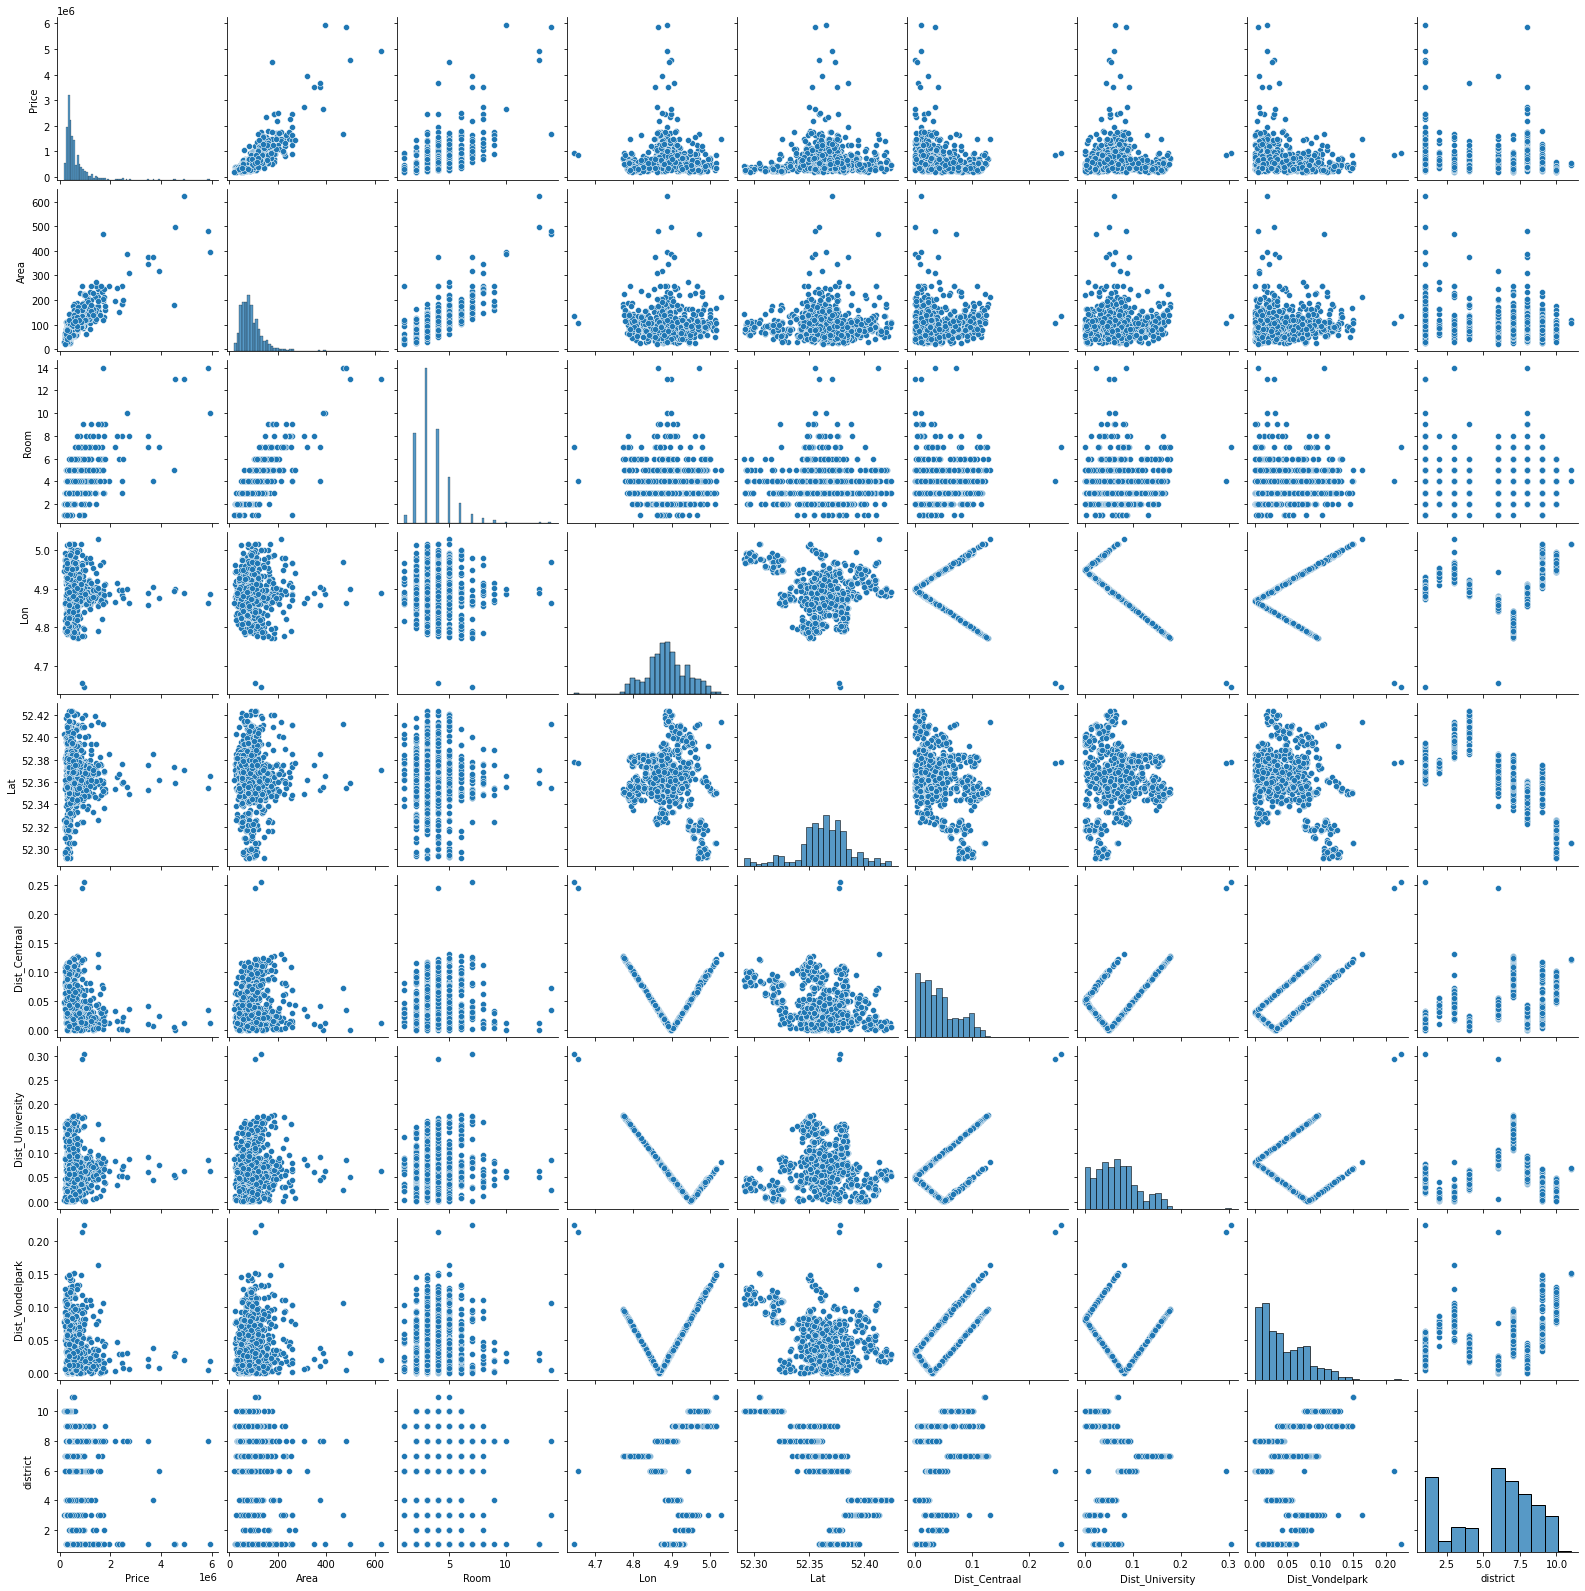

In [ ]:
fig = plt.figure(figsize=(10, 15))
sns.pairplot(df_model_2)

In [ ]:
X = df_model_2.drop(['Price'], axis = 1)
y = df_model_2["Price"]

In [ ]:
# Criando conjunto de teste e de treino
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=0.3)
# Modelo LinearRegression
lr_regr = LinearRegression()
# Treinamento do modelo
lr_regr.fit(X_train3, y_train3)
# Predição com os dados separados para teste
y_pred3 = lr_regr.predict(X_test3)
# Visualização dos 10 primeiros resultados
y_pred3[:10]

array([ 651377.01538736,  268420.48512416,  328854.81990442,
         57481.55500495,  460648.34391157,  685555.4136091 ,
        281868.91908985,  629334.18048692, 1085389.90719388,
        329637.57532333])

In [ ]:
#Calcula o valor dos resíduos para cada um dos pontos e depois a média desses resíduos.
print('Erro Médio Absoluto: %.2f' % mean_absolute_error(y_test3, y_pred3))

Erro Médio Absoluto: 125474.14


In [ ]:
#Cálculo do erro elevado ao quadrado
print('Erro Quadrático Médio: %.2f' % mean_squared_error(y_test3, y_pred3))

Erro Quadrático Médio: 37777067691.19


In [ ]:
#Proximidade dos dados da linha ajustada de 0 a 1 
print('Coeficiente de Determinação R2 Score: %.2f' % r2_score(y_test3, y_pred3))

Coeficiente de Determinação R2 Score: 0.79
